In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt  
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## implementation of

- Gaussian distribution function
- Expectation Maximazation Algorithm
- Akaike Information Criterion

In [2]:
def gaussian(x, mu, sig):
    '''
    returns the likelihood of a point in a one dimensional gaussian
    
    x x value(s)
    mu mean of the gaussian
    sig variance of the gaussian 
    '''
    return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))

In [3]:
# inspiration: https://www.youtube.com/watch?v=iQoXFmbXRJA
def em(data, k, n=1):
    '''
    vanilla 1d expectation maximazation algorithm
    
    data 1d numpy array of data
    k number of normal distributions
    n number of em repetitions
    
    returns priors, means, variances
    '''
    
    # ensure data are 1d ndarray
    data = np.array(data).flatten()
    
    # list of means and variances of the k normal distributions to be fitted
    # init randomly between min and max points of data
    min_data, max_data = data.min(), data.max() 
    
    mean = np.random.uniform(low=min_data, high=max_data, size=k)
    variance = np.random.uniform(low=np.absolute(min_data / 2), high=np.absolute(max_data/2), size=k)
    prior = np.full(k, 1 / k)  # assume priors are equal
     
    # repeat algorithm n times
    for i in range(n):
        
        p_x_b = []
        
        # loop through each distribution j
        for j in range(k):
            # calcualate for each point the generative probability that it belongs to the distribution j
            # P(x | b)
            p_x_b.append(gaussian(data, mean[j], variance[j]))
            
        # convert to numpy array
        p_x_b = np.array(p_x_b)
         
        # calculate for each point the probability that it belongs to a distribution,
        # summing up to one ('colorings of the points')
        # P(b|x)
        p_wp = p_x_b * prior.reshape(-1, 1)
        bi =  p_wp / p_wp.sum(axis=0)
         
        # reestimate means
        mean = (bi * data).sum(axis=1) / bi.sum(axis=1)
        
        # reestimate variances
        for j in range(k):
            variance[j] = (bi[j] * (data - mean[j])**2).sum() / bi[j].sum()
            
        # reestimate priors
        unique, counts = np.unique(bi.reshape(bi.shape[::-1]).argmax(axis=1), return_counts=True)
        # counts array are in the correct order the counts of points that have the max likelihood
        prior = counts / data.shape[0]
         
        
    # return means and variances
    return prior, mean, variance 

In [4]:
def aic(data, prior, mean, variance):
    '''
    return best model to the Akaike Information Criterion
    
    data 1dim data
    mean means of the gaussians
    variance variances of the gaussians
    '''
    
    K = len(mean) * 3 - 1  # len of prior, mean and variance should be the same
    
    # sum the log likelihoods of all distributions
    LL = 0
    
    for mu, sig in zip(mean, variance):
        LL += np.log(gaussian(data, mu, sig)).sum()
    
    
    return -2 * LL + 2 * K

## Plotting functions

In [5]:
 def scatter(data):
    '''
    scatter plot of 1dim data
    data 1 dim data
    '''
    
    plt.subplots(figsize=(9,2))
    plt.scatter(x, np.zeros((len(x), 1)))
    plt.yticks(())
    plt.show()
    
def plt_with_gaussians(data, mean, variance):
    '''
    scatter the data,
    and plot the given gaussian distributions
    
    data 1dim data to be scattered
    mean means of the normal distributions
    variance variances of the normal distributions
    '''
    
    plt.subplots(figsize=(14, 7))
    
      # generate x values with min and max of the data
    x_values = np.linspace(data.min(), data.max(), 1001)
    # show the gaussians 
    for mu, sig in zip(mean, variance):
        plt.plot(x_values, gaussian(x_values, mu, sig))
        
    # scatter data points on x axis
    plt.scatter(x, np.zeros((len(x), 1)))
    
    plt.yticks(())
    plt.show()

### load datasets

In [6]:
def load_iris():
    '''
    Returns a column of all petal lengths.
    '''
    X = genfromtxt("./data/iris.csv", delimiter=',', skip_header=1)
    X = X[:,2]
    X = X.reshape(-1, 1)
    return X

def load_bdp():
    '''
    Returns a column of systolic and diastolic blood pressure values.
    '''
    Z = genfromtxt("./data/bdp.csv", delimiter=',', skip_header=1)
    n = Z.shape[0]
    X = np.zeros(2*n)
    X[:n] = Z[:,2]
    X[n:] = Z[:,3]
    X = X.reshape(-1,1)
    return X

def sample(pi, mu, std, n):
    '''
    Returns a column of n values drawn from a normal mixture model.
    
    Parameter
        pi  k mixing coefficients
        mu  k means
        std k standard deviations
        n   number of data points
        
    Return
        n data points randomly sampled from specified mixture. 
    '''
    y = np.random.choice(len(pi), size=n, p=pi)
    x = np.zeros((n,1))
    for i, comp in enumerate(y):
        x[i] = norm.rvs(mu[comp], std[comp])
    return x


## Examples

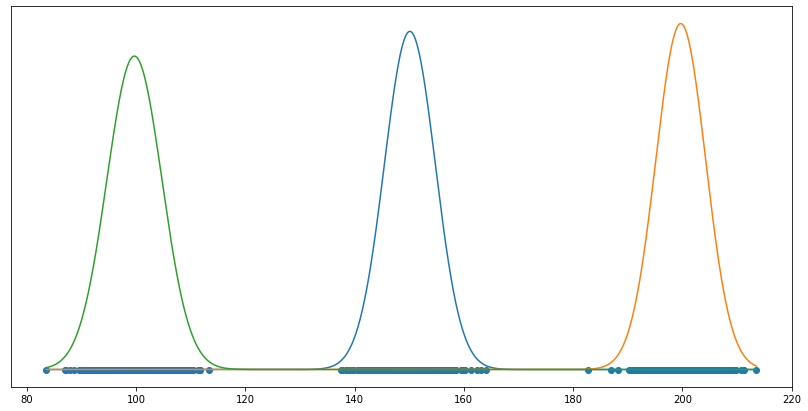

In [7]:
# generate n points from a mixture of fived normal distributions
n = 1000
mu = [100, 150, 200]
std = 5*np.ones(len(mu))
pi = np.ones(len(mu))/len(mu)
x = sample(pi, mu, std, n)

priors, mu, sig = em(x, 3, 10)
plt_with_gaussians(x, mu, sig)

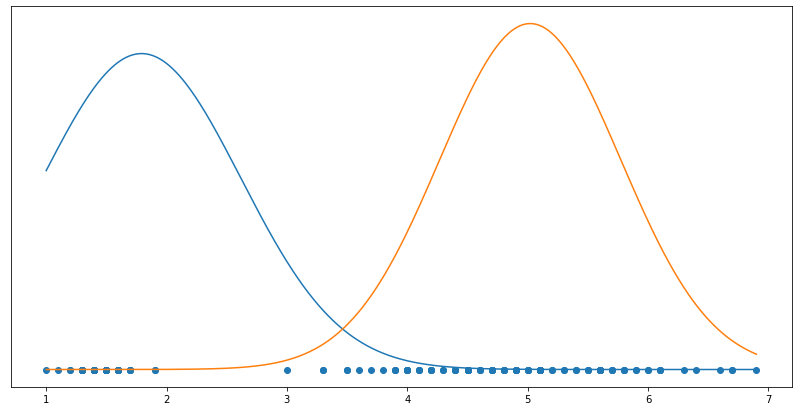

In [8]:
# load petal lengths of iris flowers
x = load_iris()
priors, mu, sig = em(x, 2, 10)
plt_with_gaussians(x, mu, sig)

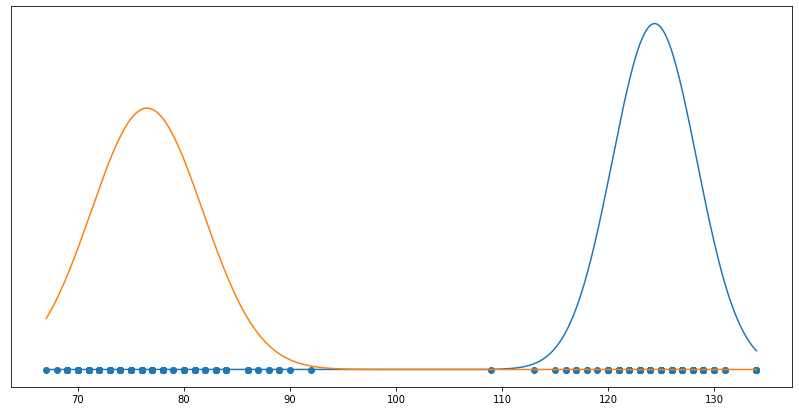

In [9]:
# load blood pressures
x = load_bdp()
priors, mu, sig = em(x, 2, 10)
plt_with_gaussians(x, mu, sig)

### compare my algorithm with sklearn's GMM

In [16]:
 for j in range(10):
    # sklearns EM / GMM
    gmm = GaussianMixture(n_components=2, init_params='kmeans', max_iter=10, reg_covar=1e-2)
    gmm.fit(x)
    
    
    # my gmm 
    my_priors, my_mu, my_sig = em(x, 2, 10)
    sk_mu, sk_sig = gmm.means_.reshape(-1), gmm.covariances_.reshape(-1)
    
    # print difference
    print(f'\n{j}')
    print(f'my mus = {my_mu}')
    print(f'sk mus = {sk_mu}')
    print(f'my sig = {my_sig}')
    print(f'sk sig = {sk_sig}')
    print(f'my aic = {aic(x, my_priors, my_mu, my_sig)}')
    print(f'sk aic = {gmm.aic(x)}')


0
my mus = [ 76.50993778 124.39735289]
sk mus = [ 76.50993532 124.39735173]
my sig = [27.68049148 15.80234984]
sk sig = [27.69041378 15.81236657]
my aic = 38031.69433598757
sk aic = 2203.913234139551

1
my mus = [124.39735128  76.50993438]
sk mus = [124.39735173  76.50993532]
my sig = [15.80237298 27.680384  ]
sk sig = [15.81236657 27.69041378]
my aic = 38031.710716307294
sk aic = 2203.913234139551

2
my mus = [124.39735128  76.50993438]
sk mus = [ 76.50993532 124.39735173]
my sig = [15.80237298 27.680384  ]
sk sig = [27.69041378 15.81236657]
my aic = 38031.710716307294
sk aic = 2203.913234139551

3
my mus = [124.39735128  76.50993438]
sk mus = [124.39735173  76.50993532]
my sig = [15.80237298 27.680384  ]
sk sig = [15.81236657 27.69041378]
my aic = 38031.710716307294
sk aic = 2203.913234139551

4
my mus = [ 76.50993778 124.39735289]
sk mus = [124.39735173  76.50993532]
my sig = [27.68049148 15.80234984]
sk sig = [15.81236657 27.69041378]
my aic = 38031.69433598757
sk aic = 2203.91323

# conduct experiment of the assignment

In [11]:
# conduct experiment